In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from models import *
from data_split import *

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))

In [10]:
n_cycles = 98
cut_start = 0

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

In [11]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3, 5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])

In [12]:
train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(y[secondary_ind]))

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, n_features, n_cycles=98):
        super(AutoEncoder, self).__init__()

        self.n_features = n_features
        self.n_cycles = n_cycles

        self.encoder = nn.Sequential(
            nn.Linear(n_features*n_cycles, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*16),
            #nn.ReLU(),
            #nn.Linear(n_features*16, n_features*8),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            #nn.Linear(n_features*8, n_features*16),
            #nn.ReLU(),
            nn.Linear(n_features*16, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*n_cycles)
        )

    def forward(self, x):
        self.eval()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded

In [21]:
class FullModel(nn.Module):
    def __init__(self, d_model, n_features, n_cycles=98, attn_model="softmax", skip_connect=0):
        super(FullModel, self).__init__()

        self.autoencoder = AutoEncoder(n_features=n_features,n_cycles=n_cycles)
        self.attn = AttentionModel2(d_model=d_model, feat_dim=1, n_cycle=n_features*16, attn_model=attn_model, skip_connect=skip_connect)

    def forward(self, x): 
        
        encoded, decoded = self.autoencoder(x)# batch_size*seq_len
        output = self.attn(encoded)
        return output,decoded

In [22]:
d_model = 2
n_features = 3
lr = 0.0001
nepoch = 500
batch_size = 1
alpha = 0.5

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [23]:
# Load nodel, loss function, and optimizer
model = FullModel(d_model=d_model, n_features=n_features, skip_connect=1)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10e-6)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output,decoded = model(train_input.to(device))
        
        pred_loss = criterion(10**output, 10**train_label)
        loss = pred_loss + alpha*criterion(train_input,decoded)
        total_loss_train += pred_loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output,_ = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output,_ = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

c:\Users\kyan3\miniconda3\envs\toyota\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 50 | rmse:  96.098 | rmse_test:  115.972 | rmse_stest:  362.849
Epochs: 100 | rmse:  90.376 | rmse_test:  306.855 | rmse_stest:  580.253
Epochs: 150 | rmse:  67.092 | rmse_test:  107.821 | rmse_stest:  364.389
Epochs: 200 | rmse:  87.483 | rmse_test:  171.597 | rmse_stest:  459.341
Epochs: 250 | rmse:  80.067 | rmse_test:  109.991 | rmse_stest:  368.588
Epochs: 300 | rmse:  60.183 | rmse_test:  110.112 | rmse_stest:  378.835
Epochs: 350 | rmse:  49.652 | rmse_test:  113.820 | rmse_stest:  395.327
Epochs: 400 | rmse:  46.664 | rmse_test:  116.512 | rmse_stest:  357.745
Epochs: 450 | rmse:  74.639 | rmse_test:  167.256 | rmse_stest:  309.497
Epochs: 500 | rmse:  84.427 | rmse_test:  107.524 | rmse_stest:  380.937


In [60]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

76.51348859710056
90.97172663234227
270.1632909498226


(0.0, 2500.0)

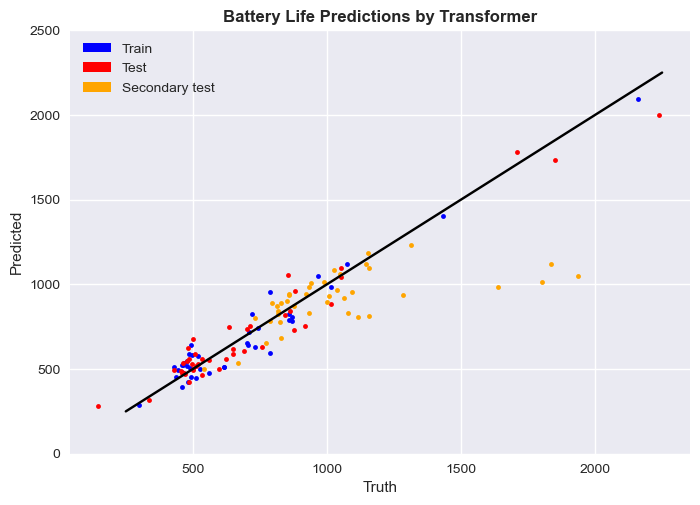

In [96]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device))[0].detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
ax.set_ylim([0,2500])
#plt.savefig("../images/transformer_output.png",dpi=300)